## Background

Recently, there has been speculation that the White House released a doctored video of an intern trying to take a microphone away from CNN reporter Jim Acosta. The claim is that the video was sped up and slowed down at certain points to make it seem like Acosta was being aggressive.

There's been a number of attempts to analyze the video frame-by-frame by hand. This is fairly subjective and error-prone. If the video is in fact edited, there happens to be an objective, mathematical way to determine exactly where and how. In this article, I will walk through these steps. To understand what's about to happen, you first need to understand how frame rate conversion works.

## Frame Rate Conversion

A video is just a series of images (**frames**) shown in quick succession. The number of different images that appear each second (**frame rate**) determines how smooth the video looks. In producing a video for the web, there is a trade-off between a frame rate that makes the video look smooth, and small file size.

Unfortunately, converting between two frame rates is usually not straightforward. Each frame in a video represents an instant in time. When you change between frame rates, the new frames usually fall at instants in time that do not have corresponding frames in the original video.

For example, this timeline shows where frames fall in a 7 fps and 5 fps video. Notice how only the first and last line up.

![](/img/doctor/offset.png)

This means that when we are converting the video, we (or our software) have to make a choice of what to do when the frames don't line up. One choice is to take the nearest frame. This way we don't have to modify any of the frames themselves, but the disadvantage is that we get jerky video because the resulting frames have uneven timing between them.

![](/img/doctor/nearest.png)

As a more concrete example, here's what this looks like on a bouncing-ball animation:

![](/img/doctor/bounce_nearest.png)

The other common approach is to blend between the two frames nearest to the instant, proportional to how close it is to each:

![](/img/doctor/bounce_fade.png)

The same problems are encountere when converting from a lower frame-rate to a higher one.

## The Accusation

The White House is accused of modifying frame timings to produce a video that works in their favor in making Acosta seem more aggressive. To test this, we can line up the frames in each video. If the video is not modified, the frames will line up in a straight line. If the line has curvature, it means that the video is faster in some places than others.

The tricky part is that the video released by the White House appears to have had its frame rate changed *twice*. As a result, most frames in the resulting video are actually a blend of two frames in the original. Take this frame from the White House's video:

<img src="/img/doctor/wh_030.jpeg" style="width: 50%" />

It appears to be a blend of these frames from the original video:

<img src="/img/doctor/160.jpeg" style="width: 50%" />
<img src="/img/doctor/161.jpeg" style="width: 50%" />

So far, none of this is evidence of tampering, just video conversion. But it makes it a little harder to say definitively which frame in the C-Span video corresponds to each frame in the White House video. Fortunately, there is a mathematical way to figure it out.

## Analysis

First, let's load in each frame as an image. I've already used [ffmpeg](https://ffmpeg.org/) to convert each video into a series of JPEGs, one for each frame. Let's get some boilerplate out of the way.

In [4]:
%matplotlib inline
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from PIL.Image import fromarray

twitter_clip = 'twitter_clip/{:03d}.jpeg'.format
actual_clip = 'actual_clip/{:03d}.jpeg'.format

You may have noticed above that the White House's video has a [chyron](https://en.wikipedia.org/wiki/Chyron) and the C-Span video does not. In order to line the frames up, we'll just select the rectangle that doesn't include any graphics. That's where all the action is, anyway.

The video clips are short enough that we can do everything in-memory, so let's load both clips into a tensor.

In [7]:
def read_image(fname):
    img = imread(fname)
    img = img[:550,:1000,:]  # crop to where the action is
    img = img.sum(2)         # convert to black and white
    return img

In [8]:
def read_video(index_to_filename, clip_start, clip_end):
    # Read each frame of the video into a tensor.
    tensor = np.stack([
        read_image(index_to_filename(i)) for i in range(clip_start, clip_end)
    ])
    # Flatten each frame into a vector.
    tensor = tensor.reshape((clip_end-clip_start, -1))
    # Transpose the result so that each column is a frame and each row is a pixel.
    return tensor.T

In [27]:
# Note: I've picked out the overlapping sections of each video by hand.
TWITTER_CLIP_START = 1
TWITTER_CLIP_END   = 107
ACTUAL_CLIP_START  = 133
ACTUAL_CLIP_END    = 240
actual_clip_frames = read_video(actual_clip, ACTUAL_CLIP_START, ACTUAL_CLIP_END)
twitter_clip_frames = read_video(twitter_clip, TWITTER_CLIP_START, TWITTER_CLIP_END)

The White House clip has had some processing, which may change the brightness or contrast. As a simple normalization step, I'll each video by the mean and divide by the standard deviation of each.

In [28]:
def normalize(frames):
    return (frames - frames.mean()) / frames.std()

In [29]:
actual_clip_frames = normalize(actual_clip_frames)
twitter_clip_frames = normalize(twitter_clip_frames)

We are interested in knowing which two frames from the original video correspond to each frame in the White House's video. I am assuming that each frame is a linear blend, so mathematically we are interested in finding $\beta$ such that:

$$ T_i = \beta_0 M_0 + \beta_1 M_1 + ... + \beta_n M_n + \epsilon $$

Where $T_i$ is the $i^{th}$ frame of the White House video, $M_i$ is the $i^{th}$ of $n$ frames of the C-Span video, and $\epsilon$ is minimized. Further, we expect that each frame is a positive combination of at most two frames from the original video, which corresponds to two restrictions on $\beta$: it has at most two non-zero elements, they are next to each other, and they are both positive.

We could write an optimizer to solve this exactly, but it turns out this is *pretty close* to what [least-angle regression](https://en.wikipedia.org/wiki/Least-angle_regression) (LARS) can do. LARS is like a linear regression, but we can tell it that we only want a certain number of non-zero coefficients, and that we want them to be positive. [Scikit-learn](https://scikit-learn.org/stable/) has an implementation.

In [59]:
from sklearn.linear_model import Lars

# Produce an N x M matrix where the rows correspond to White House
# frames and the columns correspond to C-Span frames.

frame_mappings = np.stack([
    Lars(n_nonzero_coefs=2).fit(actual_clip_frames, frame).coef_
    for frame in twitter_clip_frames.T
]).T

In [63]:
frame_mappings /= (frame_mappings.sum(0, keepdims=True))

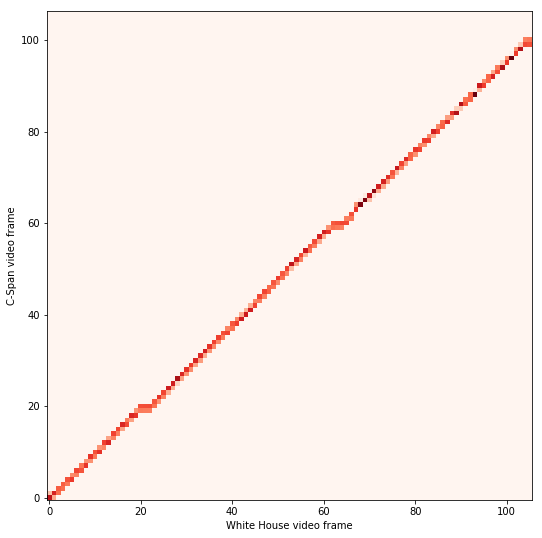

In [65]:
plt.figure(figsize=(9,9))
plt.xlabel('White House video frame')
plt.ylabel('C-Span video frame')
plt.imshow(frame_mappings, origin='bottom', cmap=plt.cm.Reds);

We can approximate the timing of each White House frame by taking a weighted average of the two C-Span frames it corresponds to:

In [75]:
approx_frames = frame_mappings.T.dot(np.arange(107))

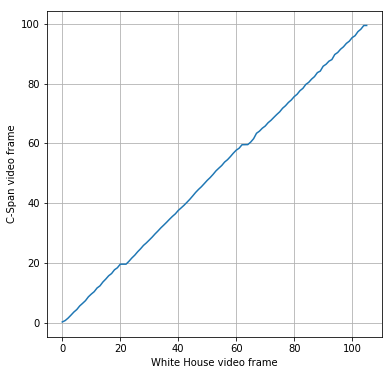

In [77]:
plt.figure(figsize=(6,6))
plt.grid(True)
plt.xlabel('White House video frame')
plt.ylabel('C-Span video frame')
plt.plot(np.arange(106), approx_frames);

Aside from a few frame freezes (which could be explained by frame rate conversion), the line has a pretty consistent slope. To be sure, we can compute plot the smoothed relative speed of the video over time. I've highlihted frames 26 - 39, where most of the action occurs and where I would have expected the video to be sped up, if at all.

In [79]:
from scipy.ndimage.filters import gaussian_filter1d

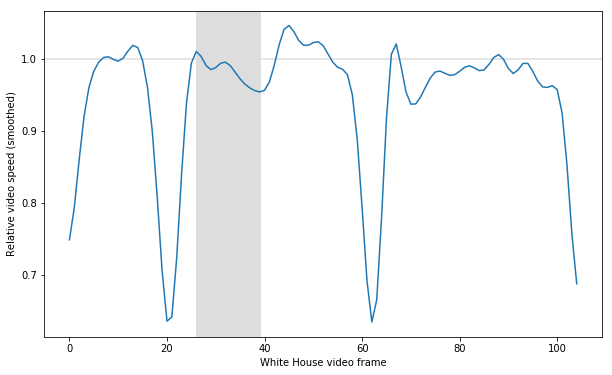

In [81]:
plt.figure(figsize=(10, 6))
plt.axhline(1, zorder=-10, c='#dddddd')
plt.axvspan(26, 39, color='#dddddd')
plt.xlabel('White House video frame')
plt.ylabel('Relative video speed (smoothed)')
plt.plot(np.arange(105), gaussian_filter1d(approx_frames[1:] - approx_frames[:-1], 2.0));

As you can see, the video is actually relatively slower in this time range. 

## Conclusion

I think this whole thing is an issue of [Hanlon's razor](https://en.wikipedia.org/wiki/Hanlon's_razor). The video appears edited because of shoddy video processing, but doesn't show evidence of being intentionally doctored.

That said, the video was a stupid distraction in the first place. Jim Acosta should get his press pass back.